In [1]:
import pandas as pd
import numpy as np

In [2]:
#Download from github and extract
!wget -N https://github.com/joechoong33/LC_loan/zipball/master
!unzip -o master
!unzip -o joechoong33-LC_loan-70a9ba3/DS-02-lendingclub-loan-data-2017q1.zip

--2020-09-23 17:51:48--  https://github.com/joechoong33/LC_loan/zipball/master
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/joechoong33/LC_loan/legacy.zip/master [following]
--2020-09-23 17:51:48--  https://codeload.github.com/joechoong33/LC_loan/legacy.zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master’

master                  [      <=>           ]  30.67M  3.51MB/s    in 8.5s    

Last-modified header missing -- time-stamps turned off.
2020-09-23 17:51:58 (3.59 MB/s) - ‘master’ saved [32161391]

Archive:  master
70a9ba35f3f311e10f41e1c531c52ad11de79b43
 extracting: joechoong33-LC_loan-70a9ba3/DS-02 len

In [3]:
df = pd.read_csv('lpetrocelli-lendingclub-loan-data-2017-q-1/LoanStats_2017Q1 2.csv',skiprows = 1)
df.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,112) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(96781, 122)

In [4]:
df_loan = df[:-2]
df_loan.tail(2)
df['int_rate'] = df['int_rate'].str.replace('%','')
df['int_rate'] = pd.to_numeric(df['int_rate'],errors='coerce')

In [5]:
# Categorize employment length
def emp_to_num(term):
    if pd.isna(term):
        return None
    elif term[2]=='+':
        return 10
    elif term[0]=='<':
        return 0
    else:
        return int(term[0])

df['emp_length_num'] = df['emp_length'].apply(emp_to_num)

In [6]:
#Feature engineer - basically lender credit status
df.loc[:, 'flag'] = np.where((df.purpose == 'debt_consolidation') | (df.purpose == 'credit_card'),1.0, -1.0)
df['install_loan_ratio'] = (df['installment'] / df['loan_amnt']) * 100
df['long_emp'] = df['emp_length'].apply(lambda x: 1*(x=='10+ years'))
df['short_emp'] = df['emp_length'].apply(lambda x: 1*(x=='1 year' or x=='< 1 year'))


In [7]:
#Predict for good and bad - map loan status into 0 and 1
df['target']=df['loan_status'].map({'Current': 1,'Issued': 1, 'Fully Paid': 1, 'In Grace Period': 0, 'Late (31-120 days)':0, 'Late (16-30 days)': 0})

In [8]:
# Huge class imbalance
df['target'].value_counts(normalize=True)

1.0    0.994214
0.0    0.005786
Name: target, dtype: float64

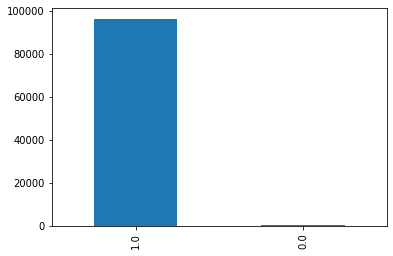

In [9]:
# Huge class imbalance
df['target'].value_counts().plot(kind='bar')

In [10]:
#tranform annual income to log
df['annual_inc_log'] = df['annual_inc'].apply(np.log)

In [11]:
columns = ['loan_amnt', 'term', 'int_rate','flag','install_loan_ratio',
       'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc_log', 'verification_status',
       'target', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc']
df = df[columns]

df.dropna(inplace=True)

In [12]:
# Map grade to integer
df['grade']=df['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

In [13]:
#Copy dataframe
df_dummies = pd.get_dummies(df) 

In [14]:
drop_columns = df_dummies.columns[(df_dummies.mean()<0.01)]
df_dummies.drop(drop_columns, axis=1, inplace=True)

In [15]:
df_dummies['verification_status_Verified_sum'] = df_dummies['verification_status_Source Verified']+df_dummies['verification_status_Verified']
df_dummies.drop(['verification_status_Source Verified', 'verification_status_Verified'], axis=1, inplace=True)


df_dummies = df_dummies.rename(columns={'emp_length_10+ years':'emp_length_10 years','emp_length_< 1 year':'emp_length_less 1 year'})

In [16]:
# After cleaning, prepare training data
X = df_dummies.drop('target', axis=1)
y = df_dummies['target']
X.shape

(89940, 67)

In [17]:
#Drop zip code of states
drop_list1 = ['addr_state_AL',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_FL', 'addr_state_GA', 'addr_state_IL', 'addr_state_IN',
       'addr_state_LA', 'addr_state_MA', 'addr_state_MD', 'addr_state_MI',
       'addr_state_MN', 'addr_state_MO', 'addr_state_NC', 'addr_state_NJ',
       'addr_state_NV', 'addr_state_NY', 'addr_state_OH', 'addr_state_OR',
       'addr_state_PA', 'addr_state_SC', 'addr_state_TN', 'addr_state_TX',
       'addr_state_VA', 'addr_state_WA', 'addr_state_WI']

X.drop(drop_list1,axis=1,inplace=True)

In [18]:
# Build train and test set > 80:20
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify = y,random_state=0) #0 6 = 0.698


In [ ]:
#Save train and test data to environment folder
#train = pd.concat([X_train,y_train],axis=1)
#test = pd.concat([X_test,y_test],axis=1)

#train.to_csv('train.csv',index=False,header=False)

#test.to_csv('test.csv',index=False,header=False)